In [1]:
import sys, pathlib, pandas as pd

# point ROOT to project root so we can load data and src
ROOT = pathlib.Path.cwd().parent if pathlib.Path.cwd().name == "notebooks" else pathlib.Path.cwd()
sys.path.append(str(ROOT))                # <– makes `import src.…` work

DATA = ROOT / "data" / "healthcare-dataset-stroke-data.csv"
df = pd.read_csv(DATA)


In [2]:

import importlib, src.preprocessing as pp      # pp is just an alias
importlib.reload(pp)                           # pulls the latest file contents

num_cols, cat_cols = pp.get_feature_lists(df, "stroke")

num_cols = [col for col in num_cols if col != "id"]  # Exclude 'id' from numeric columns

# Ensure 'stroke' is not in the feature columns
feature_cols = num_cols + cat_cols

X = df[feature_cols]
y = df["stroke"].astype(int)

print(f"{X.shape[0]} rows, {len(num_cols)} numeric, {len(cat_cols)} categorical")


5110 rows, 5 numeric, 5 categorical


In [3]:
from sklearn.linear_model import LogisticRegression

pipe = pp.make_pipeline(
    LogisticRegression(C=0.1, max_iter=100, penalty='l1', solver='liblinear'),
    numeric_cols=num_cols,
    categorical_cols=cat_cols,
    random_state=42,
)
pipe


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scale',
                                                                   RobustScaler())]),
                                                  ['age', 'hypertension',
                                                   'heart_disease',
                                                   'avg_glucose_level',
                                                   'bmi']),
                                                 ('cat',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encode',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['gender', 'ever_married',
                                                   'work_type',
                                                   'Residence_type',
                                                   'smoking_status'])])),
                ('oversample', SMOTE(random_state=42)),
                ('model',
                 LogisticRegression(C=0.1, penalty='l1', solver='liblinear'))])

In [4]:
# train- test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [5]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

param_grid = {
    "model__penalty": ["l1", "l2"],
    "model__C": np.logspace(-3, 2, 6),
    "model__max_iter": [100, 500, 1000],
    "model__solver": ["liblinear", "saga"],  # Both support 'l1' and 'l2'
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    scoring=make_scorer(f1_score, average="binary"),
    n_jobs=-1,
    cv=cv,
    verbose=1,
)


grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best score:", grid.best_score_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best params: {'model__C': 0.1, 'model__max_iter': 100, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best score: 0.2281808798536792



Threshold = 0.700
              precision    recall  f1-score   support

           0      0.983     0.854     0.914       972
           1      0.202     0.720     0.316        50

    accuracy                          0.847      1022
   macro avg      0.593     0.787     0.615      1022
weighted avg      0.945     0.847     0.885      1022

ROC-AUC : 0.842366255144033


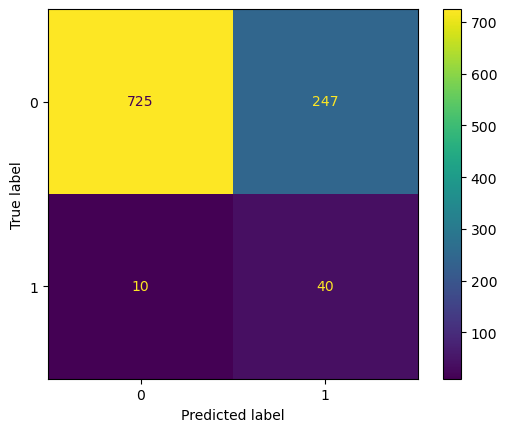

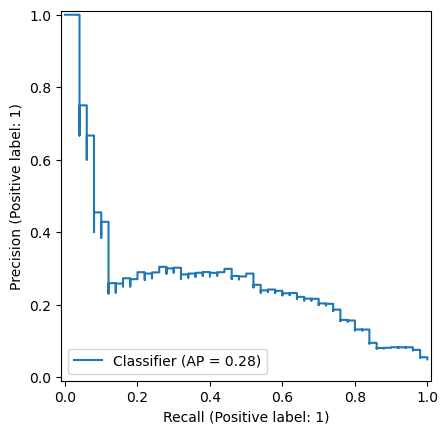

In [10]:
import importlib, src.evaluate as Ev      # pp is just an alias
importlib.reload(Ev)   

pipe.fit(X_train, y_train)
y_prob = pipe.predict_proba(X_test)[:, 1]  # Probability for class 1
threshold = 0.7 # Default threshold for binary classification
Ev.evaluate_at(threshold, y_test, y_prob)
Ev.Display(pipe, X_test, y_test)
